In [3]:
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from util import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%load_ext autoreload
%autoreload 1

In [4]:
instance = loadInstance(1)

In [28]:
instance.Products

[    1    11]

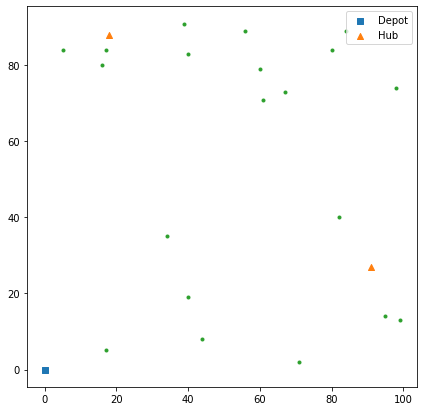

In [5]:
plotInstance(instance)

In [6]:
def locIDtoHubID(loc_ID):
    return loc_ID - 1

def hubIDtoLocID(hub_ID):
    return hub_ID + 1

In [7]:
def distance(loc1: InstanceCO22.Location, loc2: InstanceCO22.Location, ceil: bool = True) -> float:
    dist =  math.sqrt((loc1.X - loc2.X)**2 + (loc1.Y - loc2.Y)**2)
    if ceil:
        return math.ceil(dist)
    else:
        return dist

In [8]:
def requestClosestHub(instance: InstanceCO22, request: InstanceCO22.Request) -> int:
    nHubs = len(instance.Hubs)
    hubs = instance.Locations[1:nHubs+1]
    minDist = math.inf
    minDistHubLocID = None
    for i, hub in enumerate(hubs):
        if request.ID in instance.Hubs[i].allowedRequests:
            hubDist = distance(instance.Locations[request.customerLocID-1],hub)
            if hubDist < minDist:
                minDist = hubDist
                minDistHubLocID = hub.ID
    return minDistHubLocID

In [9]:
def requestsClosestHub(instance: InstanceCO22) -> dict:
    #return dictionary of {'LOC_ID': ' NEAREST LOC_ID'}
    res = {}
    for req in instance.Requests:
        res[req.ID] = requestClosestHub(instance, req)
    return res

In [10]:
def requestsPerHub(instance: InstanceCO22) -> dict:
    closestHubPerRequest = requestsClosestHub(instance= instance)
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    res = {val: [] for val in hubLocIDs}
    for hubLocID in hubLocIDs:
        for reqID, closestHubLocID in closestHubPerRequest.items():
            if closestHubLocID is hubLocID:
                res[hubLocID].append(reqID)
    return res

In [11]:
def amountPerProduct(instance: InstanceCO22, requests: list) -> list:
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res

In [12]:
def filterRequests(instance: InstanceCO22, day: int = None, locationsID: int = None) -> list:
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res

In [13]:
def addAllEdges(G: nx.DiGraph, checkWindowOverlap: bool = False) -> nx.DiGraph:
    for locID1, node1 in G.nodes(data=True):
        for locID2, node2 in G.nodes(data=True):
            if locID1 != locID2:
                if checkWindowOverlap and locID1 not in ["Source","Sink"] and locID2 not in ["Source", "Sink"] and not windowOverlap(node1['periodIDs'], node2['periodIDs']):
                        continue
                dist = math.ceil( math.sqrt( pow(node1['X']-node2['X'],2) + pow(node1['Y']-node2['Y'],2) ))
                if locID1 == "Sink" or locID2 == "Source" or (locID1 == "Source" and locID2 == "Sink"):
                    continue
                else:
                    G.add_edge(locID1, locID2, time = dist, cost=dist)   
    return G        

In [14]:
def createNxHub(instance: InstanceCO22, hubLocID: int, requests: list) -> nx.DiGraph:
    G = nx.DiGraph()
    for req in requests:
        reqLoc = instance.Locations[req.customerLocID-1]
        G.add_node(req.ID, locID = reqLoc.ID, reqID = req.ID, X=reqLoc.X, Y=reqLoc.Y, demand = sum(req.amounts), amounts = req.amounts)
    hubLoc = instance.Locations[hubLocID]
    G.add_node("Source", locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G.add_node("Sink",locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G = addAllEdges(G)
    return G

In [15]:
def solveHubVRP(instance: InstanceCO22, hubLocID: int, requests: list) -> dict:
    #create networkX
    G = createNxHub(instance, hubLocID, requests)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    #print(G_dict.keys())
    prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
    prob.duration = instance.VanMaxDistance
    prob.fixed_cost = instance.VanDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {
        'routes': {key: {'route': [G_dict[id] for id in best_routes[key]]} for key in best_routes.keys()},
        'demand': sum([sum(req.amounts) for req in requests]),
        'amounts': amountPerProduct(instance, requests)
    }
    return res

In [16]:
def createNxDepot(instance: InstanceCO22, dayRoutes: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    #add hubs
    for hubLocID, hubData in dayRoutes.items():
        G.add_node(hubLocID, locID = hubLocID, demand = hubData['demand'], amounts= hubData['amounts'], X=instance.Locations[hubLocID].X, Y=instance.Locations[hubLocID].Y)

    G.add_node("Source", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)
    G.add_node("Sink", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)

    G = addAllEdges(G)
    return G

In [17]:
def solveDepotVRP(instance: InstanceCO22, dayRoutes: dict) -> dict:
    #for solving per day
    G = createNxDepot(instance, dayRoutes)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    print(G_dict.keys())

    prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
    prob.duration = instance.TruckMaxDistance
    prob.fixed_cost = instance.TruckDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {key: [G_dict[id] for id in best_routes[key]] for key in best_routes.keys()}
    return res

In [18]:
def solveHub(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    return hubRoutes

In [19]:
class timeWindowGenerator(object):
    def __init__(self, day_length=1000, padding=200, n=20):
        res = []
        for i in range(0,n):
            begin = day_length*i + padding*i
            window = [begin, begin+day_length ]
            res.append(window)
        self.windows = res

    def getWindow(self, d1, d2):
        return [self.windows[d1-1][0], self.windows[d2-1][1]], list(range(d1,d2+1))

In [31]:
twg = timeWindowGenerator(1000,200,20)
twg.windows

[[0, 1000],
 [1200, 2200],
 [2400, 3400],
 [3600, 4600],
 [4800, 5800],
 [6000, 7000],
 [7200, 8200],
 [8400, 9400],
 [9600, 10600],
 [10800, 11800],
 [12000, 13000],
 [13200, 14200],
 [14400, 15400],
 [15600, 16600],
 [16800, 17800],
 [18000, 19000],
 [19200, 20200],
 [20400, 21400],
 [21600, 22600],
 [22800, 23800]]

In [20]:
def windowOverlap(w1, w2):
    return bool(set(w1) & set(w2))

In [62]:
def giantDepotNx(hubRoute: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    twg = timeWindowGenerator(1000,200,20)
    daysFresh = [_.daysFresh for _ in instance.Products]
    productIDs = list(range(1, len(instance.Products)+1))
    for day, dayRoute in hubRoute.items():  # for every day
        for hubLocID, hubData in dayRoute.items():  # for every hub
            for productID in productIDs:
                productDemand = hubData['amounts'][productID-1]
                if productDemand > 0:
                    d1 = max(day - daysFresh[productID-1]+1, 1)
                    window, periodIDs = twg.getWindow(d1=d1, d2=day)
                    upper = window[1]
                    lower = window[0]
                    nodeID = f"d{day}h{hubLocID}p{productID}"
                    G.add_node(
                        nodeID,
                        X=instance.Locations[hubLocID].X,
                        Y=instance.Locations[hubLocID].Y,
                        upper=upper,
                        lower=lower,
                        day=day,
                        periodIDs = periodIDs,
                        productID=productID,
                        hubLocID=hubLocID,
                        demand=productDemand)

    G.add_node("Source", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G.add_node("Sink", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G = addAllEdges(G, checkWindowOverlap=True)
    return G

In [63]:
%%capture
res = solveHub(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 308 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 308 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 308.0
INFO:vrpy.master_solve_pulp:total cost = 308.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 194 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 194 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 194.0
INFO:vrpy.master_solve_pulp:total cost = 194.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 208 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 208 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 208.0
INFO:vrpy.master_solve_pulp:total cost = 208.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 302 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 302 and 1 vehic

In [64]:
G = giantDepotNx(res)

In [65]:
len(G.nodes(data=True))
len(G.edges())

688

In [45]:
G.edges(data=True)

OutEdgeDataView([('d1h2p1', 'd1h3p1', {'time': 52, 'cost': 52}), ('d1h2p1', 'd2h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd2h3p1', {'time': 52, 'cost': 52}), ('d1h2p1', 'd3h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd4h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd4h3p1', {'time': 52, 'cost': 52}), ('d1h2p1', 'd5h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd5h3p1', {'time': 52, 'cost': 52}), ('d1h2p1', 'd6h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd8h3p1', {'time': 52, 'cost': 52}), ('d1h2p1', 'd9h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd10h2p1', {'time': 0, 'cost': 0}), ('d1h2p1', 'd10h3p1', {'time': 52, 'cost': 52}), ('d1h2p1', 'Sink', {'time': 95, 'cost': 95}), ('d1h3p1', 'd1h2p1', {'time': 52, 'cost': 52}), ('d1h3p1', 'd2h2p1', {'time': 52, 'cost': 52}), ('d1h3p1', 'd2h3p1', {'time': 0, 'cost': 0}), ('d1h3p1', 'd3h2p1', {'time': 52, 'cost': 52}), ('d1h3p1', 'd4h2p1', {'time': 52, 'cost': 52}), ('d1h3p1', 'd4h3p1', {'time': 0, 'cost': 0}), ('d1h3p1', 'd5h2p1', {'time': 52, 'cost':

In [46]:
G.nodes(data=True)

NodeDataView({'d1h2p1': {'X': 91, 'Y': 27, 'upper': 10000, 'lower': 0, 'day': 1, 'periodIDs': [1], 'productID': 1, 'hubLocID': 2, 'demand': 4}, 'd1h3p1': {'X': 40, 'Y': 19, 'upper': 10000, 'lower': 0, 'day': 1, 'periodIDs': [1], 'productID': 1, 'hubLocID': 3, 'demand': 8}, 'd2h2p1': {'X': 91, 'Y': 27, 'upper': 22000, 'lower': 0, 'day': 2, 'periodIDs': [1, 2], 'productID': 1, 'hubLocID': 2, 'demand': 1}, 'd2h3p1': {'X': 40, 'Y': 19, 'upper': 22000, 'lower': 0, 'day': 2, 'periodIDs': [1, 2], 'productID': 1, 'hubLocID': 3, 'demand': 9}, 'd3h2p1': {'X': 91, 'Y': 27, 'upper': 34000, 'lower': 0, 'day': 3, 'periodIDs': [1, 2, 3], 'productID': 1, 'hubLocID': 2, 'demand': 20}, 'd4h2p1': {'X': 91, 'Y': 27, 'upper': 46000, 'lower': 0, 'day': 4, 'periodIDs': [1, 2, 3, 4], 'productID': 1, 'hubLocID': 2, 'demand': 8}, 'd4h3p1': {'X': 40, 'Y': 19, 'upper': 46000, 'lower': 0, 'day': 4, 'periodIDs': [1, 2, 3, 4], 'productID': 1, 'hubLocID': 3, 'demand': 14}, 'd5h2p1': {'X': 91, 'Y': 27, 'upper': 58000,

In [66]:
instance.TruckMaxDistance

1000

In [61]:
instance.TruckCapacity

120

In [67]:
%%capture
prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
prob.duration = instance.TruckMaxDistance
prob.fixed_cost = instance.TruckDayCost
prob.time_windows = True
prob.dive=True
prob.solve()

INFO:vrpy.vrp:new upper bound : max num stops = 24
INFO:vrpy.vrp:iteration 0, 10300.
INFO:vrpy.vrp:iteration 1, 5834.0
INFO:vrpy.vrp:iteration 2, 5548.0
INFO:vrpy.vrp:iteration 3, 5548.0
INFO:vrpy.vrp:iteration 4, 5548.0
INFO:vrpy.vrp:iteration 5, 5548.0
INFO:vrpy.vrp:iteration 6, 5546.0
INFO:vrpy.vrp:iteration 7, 5546.0
INFO:vrpy.vrp:iteration 8, 5415.9
INFO:vrpy.vrp:iteration 9, 5415.9
INFO:vrpy.vrp:iteration 10, 5415.9
INFO:vrpy.vrp:iteration 11, 5415.9
INFO:vrpy.vrp:iteration 12, 5415.9
INFO:vrpy.vrp:iteration 13, 5415.9
INFO:vrpy.vrp:iteration 14, 5415.9
INFO:vrpy.vrp:iteration 15, 5415.9
INFO:vrpy.vrp:iteration 16, 5400.2
INFO:vrpy.vrp:iteration 17, 5378.8
INFO:vrpy.vrp:iteration 18, 5378.8
INFO:vrpy.vrp:iteration 19, 5378.8
INFO:vrpy.vrp:iteration 20, 5370.4
INFO:vrpy.vrp:iteration 21, 5370.4
INFO:vrpy.vrp:iteration 22, 5362.4
INFO:vrpy.vrp:iteration 23, 5362.4
INFO:vrpy.vrp:iteration 24, 5358.2
INFO:vrpy.vrp:iteration 25, 5351.0
INFO:vrpy.vrp:iteration 26, 5351.0
INFO:vrpy.vrp:

In [68]:
prob.best_routes_load

{1: 5,
 2: 3,
 3: 6,
 4: 2,
 5: 6,
 6: 6,
 7: 4,
 8: 7,
 9: 2,
 10: 26,
 11: 5,
 12: 14,
 13: 7,
 14: 9,
 15: 8,
 16: 19,
 17: 118}

In [69]:
prob.best_routes

{1: ['Source', 'd10h3p1', 'Sink'],
 2: ['Source', 'd12h2p1', 'Sink'],
 3: ['Source', 'd12h3p1', 'Sink'],
 4: ['Source', 'd13h2p1', 'Sink'],
 5: ['Source', 'd13h3p1', 'Sink'],
 6: ['Source', 'd14h2p1', 'Sink'],
 7: ['Source', 'd14h3p1', 'Sink'],
 8: ['Source', 'd15h2p1', 'Sink'],
 9: ['Source', 'd15h3p1', 'Sink'],
 10: ['Source', 'd16h2p1', 'Sink'],
 11: ['Source', 'd17h2p1', 'Sink'],
 12: ['Source', 'd17h3p1', 'Sink'],
 13: ['Source', 'd18h3p1', 'Sink'],
 14: ['Source', 'd19h2p1', 'Sink'],
 15: ['Source', 'd19h3p1', 'Sink'],
 16: ['Source', 'd20h3p1', 'Sink'],
 17: ['Source',
  'd2h3p1',
  'd1h3p1',
  'd5h3p1',
  'd4h3p1',
  'd8h3p1',
  'd1h2p1',
  'd4h2p1',
  'd6h2p1',
  'd3h2p1',
  'd2h2p1',
  'd5h2p1',
  'd9h2p1',
  'd10h2p1',
  'd20h2p1',
  'Sink']}

In [72]:
prob.best_routes_duration

{1: 90,
 2: 190,
 3: 90,
 4: 190,
 5: 90,
 6: 190,
 7: 90,
 8: 190,
 9: 90,
 10: 190,
 11: 190,
 12: 90,
 13: 90,
 14: 190,
 15: 90,
 16: 90,
 17: 192}

In [73]:
prob.arrival_time[17]

{'Source': 0,
 'd2h3p1': 45,
 'd1h3p1': 45,
 'd5h3p1': 45,
 'd4h3p1': 45,
 'd8h3p1': 45,
 'd1h2p1': 97,
 'd4h2p1': 97,
 'd6h2p1': 97,
 'd3h2p1': 97,
 'd2h2p1': 97,
 'd5h2p1': 97,
 'd9h2p1': 97,
 'd10h2p1': 97,
 'd20h2p1': 10800,
 'Sink': 10895}

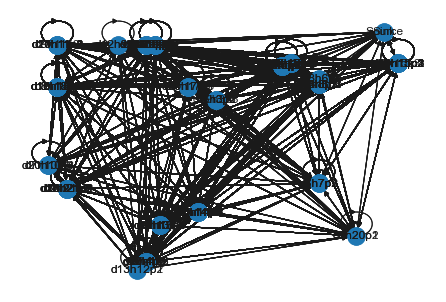

In [39]:
pos = {id: (val['X'],val['Y']) for id,val in G.nodes(data=True)}
nx.draw(G, with_labels=True, pos = pos)

In [63]:
def solve(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    depotRoutes = {}
    for day in range(1, nDays+1):  
        if len(hubRoutes[day])>0:                                                #depot routing
            res = solveDepotVRP(instance, hubRoutes[day])
            depotRoutes[day] = res
        else:
            depotRoutes[day] = {}
    return {'hubRoutes': hubRoutes, 'depotRoutes': depotRoutes}

In [64]:
%%capture
res = solve(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 472.0
INFO:vrpy.master_solve_pulp:total cost = 472.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 422.0
INFO:vrpy.master_solve_pulp:total cost = 422.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 444.0
INFO:vrpy.master_solve_pulp:total cost = 444.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 508 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 508 and 1 vehic

In [65]:
print(pprint.pformat(res))

{'depotRoutes': {1: {1: [{'X': 87,
                          'Y': 92,
                          'collect': 0,
                          'demand': 0,
                          'frequency': 1,
                          'locID': 1,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 73,
                          'Y': 72,
                          'amounts': [0, 4, 3],
                          'collect': 0,
                          'demand': 7,
                          'frequency': 1,
                          'locID': 8,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 39,
                          'Y': 18,
                          'amounts': [8, 5, 0],
                          'collect': 0,
                          'demand': 13,
                          'frequency': 1,
          

In [66]:
def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"
        nTrucks = len(res['depotRoutes'][day])
        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"

        truckString = ""
        for routeID, truckRoute in res['depotRoutes'][day].items():
            truckString += f"{routeID} "
            for i, hubData in enumerate(truckRoute[1:-1]):
                amountPerProduct = hubData['amounts']
                truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
            truckString += "\n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i+=1
                reqIds = [_['reqID'] for _ in route['route'][1:-1] ]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"  
        resultString += vanString + "\n"
    return resultString
    

In [67]:
solutionStr = solutionToStr(instance,res)
with open("./solution_test_alg1.txt" ,'w') as file:
    file.write(solutionStr)


In [ ]:
#assign hub to locations
#for each day, for each hub:
    #get request for hub, day
    #turn into networkX graph
    #solve using vrpy
    #store results
